# Versuch 7 
## Verbrennungswärme einer festen organischen Substanz
Zu Beginn werden alle für die Auswertung notwendigen Module importiert. Welche Module könntet ihr wie üblich für die Auswertung brauchen? Die allgemeinen bereits bekannten und vorausgetzten Python-Kompetenzen könnt ihr unter [Anforderungen.ipynb](Anforderungen.ipynb) nachlesen. Dort sind auch einige Ratschläge bspw. zum Exportieren von Grafiken oder Hinweise zu <code>NumPy</code> aufgeführt.

Falls euch nachträglich Module einfallen, könnt ihr diese jederzeit hier ergänzen. Achtet dabei aber darauf, den entsprechenden Code dann auch erneut auszuführen!

In [1]:
from Hilfsdateien.importe_Bibliotheken import *

Außerdem könnten einige Naturkonstanten später in der Auswertung hilfreich sein. Diese können wir aus <code>scipy.constants</code> importieren. Hilfreich kann außerdem sein, weitere Konstanten wie den Studentschen $t$-Wert zu Beginn zu definieren und für dieses Experiment insbesondere die Standardbildungsenthalpien der Substanzen!

In [2]:
from Hilfsdateien.importe_Konstanten import *

H_f_benzoe = -3.851e5 #J/mol
H_f_co2 = -3.9351e5 #J/mol
H_f_h2o = -2.8583e5 #J/mol
H_f_o2 = 0 #J/mol

M_benzoe = 0.12212 #kg/mol
M_zucker = 0.34230 #kg/mol

m_benzoe = np.array([0.4047,0.2782,0.2872])/1000 #kg
m_zucker = np.array([1.1005,0.7721])/1000 #kg
m_haribo = 0.9082/1000 #kg

## Erster Auswertungsschritt
Wie üblich wollen wir zunächst alle unsere Messdaten einlesen. Idealerweise definieren wir pro Substanz in je einem Array alle Massen (also ein Array für Benzoesäure, einer für Saccharose,…). Hierbei werdet ihr vermutlich mit folgendem Problem umgehen müssen: Die Messreihen sind vermutlich unterschiedlich lang, sodass einem leeren 3D-Array die Werte nicht ohne Weiteres mittels einer Schleife zugewiesen werden können – es würde eine Fehlermeldung wegen der unterschiedlichen Dimensionen erscheinen. Allerdings könnt ihr ein mit <code>np.nan</code> gefülltes 3D-Array erstellen, welches sich an der Größe der längsten Messreihe orientiert. Daher sollt ihr nun bei $n$ Messreihen mit maximal $j$ Messwertepaaren und $k$ Messgrößen je Substanz ein 3D-Array mit den entsprechenden Dimensionen erstellen. 

In [3]:
#Dimensionen des Array
n,j,k = 3,11403,2
benzoe = np.full((n,j,k),np.nan)
#haribo ist nur eine Messung, daher nicht notwendig
zucker = np.full((n,j,k),np.nan)

Über diese Arrays soll nun je Substanz iteriert werden. Mittels <code>enumerate</code> kann sowohl ein Index als auch der Wert eines Elements in einem Array übertragen werden. Die erste Variable ist immer der Index und die Zweite der Eintrag im Array. Wir wollen enumerate über ein Array laufen lassen, welches die Pfade zu unseren Messwerten enthält. Welcher Befehl _generiert_ uns NumPy-Arrays aus bspw. txt-Dateien?

Wichtig: Da als Dezimaltrennzeichen im Datensatz ein Komma anstatt eines Punktes verwendet wird, müssen wir entweder manuell vorher alle Kommas mit Punkten im Datensatz ersetzen __oder__ Python konvertiert die Kommas in Punkte. Durch eine [Internetrecherche](https://github.com/numpy/numpy/issues/13810#issuecomment-504675321) kann eine einfache Methode zum Umgang mit dem Problem gefunden werden (<code>converters</code> klappt auch mit einem anderen euch bekannten NumPy-Befehl und das Modul <code>io</code> ist _nicht_ notwendig).

In [4]:
#3 Messreihen Benzoesäure
for number in np.arange(1,4):
    benz = np.genfromtxt("data_v7/Benz"+str(number),converters = {0: lambda s: float(s.decode("UTF-8").replace(",", ".")),1: lambda s: float(s.decode("UTF-8").replace(",", "."))},usecols=(0,1),dtype=float) 
    benzoe[number-1,:benz.shape[0]] = benz
#2 Messreihen Zucker
for number in np.arange(1,3):
    zuck = np.genfromtxt("data_v7/Zucker"+str(number),converters = {0: lambda s: float(s.decode("UTF-8").replace(",", ".")),1: lambda s: float(s.decode("UTF-8").replace(",", "."))},usecols=(0,1),dtype=float)
    zucker[number-1,:zuck.shape[0]] = zuck
#1 Messreihe Haribos
haribo = np.genfromtxt("data_v7/haribo",converters = {0: lambda s: float(s.decode("UTF-8").replace(",", ".")),1: lambda s: float(s.decode("UTF-8").replace(",", "."))},usecols=(0,1),dtype=float)
print(np.shape(benzoe))

(3, 11403, 2)


Anschließend soll aus diesen Daten nun die Änderung der inneren Energie unter isochoren Bedingungen, $\Delta_\mathrm{v} U$, bestimmt werden. Nach der im Skript gegeben Gleichung
\begin{align}
\Delta_\mathrm{v}H = \Delta_\mathrm{v}U + R\cdot T\cdot\sum_i \nu_{i,\mathrm{gas}}
\end{align}
kann bei einer Temperatur $T$ und den stöchiometrischen Koeffizienten $\nu$ eines Gases $i$ die gewünschte Größe bestimmt werden. Die Verbrennungsenthalpie $\Delta_\mathrm{v}H$ ist nach dem Satz von Hess zu bestimmen.

Mit Hilfe von <code>sympy</code> soll nachfolgend die Änderung der inneren Energie bestimmt werden. Hierzu soll zunächst die obige Gleichung mittels sympy definiert werden, im Idealfall bereits nach $\Delta_\mathrm{v}U$ umgestellt. Die notwendigen Ableitungen kann dann sympy für uns berechnen.

In [5]:
Hv,T,dT,nu_ges = symbols('H_v T dT ν_ges')
Uv = R*T*nu_ges - Hv
dUv = sqrt((diff(Uv,T)*dT)**2)

Uv = lambdify([Hv,T,nu_ges],Uv,'scipy')
dUv = lambdify([Hv,T,dT,nu_ges],dUv,'scipy')

Als Temperatur $T$ kann die Temperatur vor dem Temperaturanstieg genommen werden oder der Einfachheit halber der Mittelwert über alle Messwerte (was sind mögliche Vor- und Nachteile der Methoden?)

Für alle drei Messungen sollten die Ergebnisse für $\Delta_\mathrm{v}U$ in einem Array gespeichert werden. Da wir dessen Werte noch nicht kennen, soll zunächst ein leeres Array für $\Delta_\mathrm{v}U$ und dessen Unsicherheit erstellt werden. 

In [6]:
U_v = np.empty(3)
dU_v = np.empty(3)
H_v = -3.227e6 #j/mol

Zunächst wollen wir uns die Kurven anschauen, um den Zeitpunkt des Temperaturanstiegs im Datensatz zu finden. Außerdem können wir so überlegen, über welche Bereiche man Ausgleichsgeraden ziehen könnte, anhand derer der Temperaturanstieg bestimmt wird.

Mittels einer for-Schleife soll nun über die einzelnen Messungen iteriert werden und die Temperaturkurven geplottet werden.

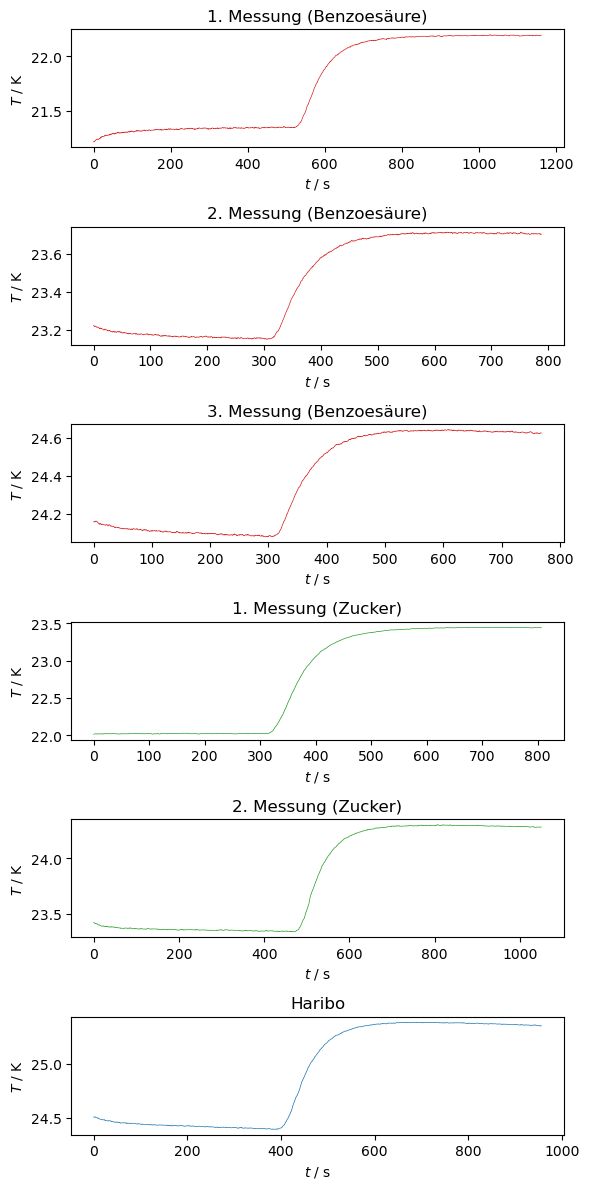

In [7]:
fig, ax = plt.subplots(nrows=6,figsize=(6,12))
for i in range(6):
    if i < 3:
        ax[i].plot(benzoe[i,:,0],benzoe[i,:,1],color='tab:red',lw=0.5)
        ax[i].set_title(str(i+1) + ". Messung (Benzoesäure)")
        ax[i].set_ylabel("$T$ / K")
        ax[i].set_xlabel("$t$ / s")
    elif i == 5:
        ax[i].plot(haribo[:,0],haribo[:,1],color='tab:blue',lw=0.5)
        ax[i].set_title("Haribo")
        ax[i].set_ylabel("$T$ / K")
        ax[i].set_xlabel("$t$ / s")
    else:
        ax[i].plot(zucker[i-3,:,0],zucker[i-3,:,1],color='tab:green',lw=0.5)
        ax[i].set_title(str(i+1-3) + ". Messung (Zucker)")
        ax[i].set_ylabel("$T$ / K")
        ax[i].set_xlabel("$t$ / s")
plt.tight_layout()    
plt.show()
#plt.savefig('fig.pdf')
plt.close()

In einem Array sollen nun sinnvolle Ober- und Untergrenzen des Bereichs, über den jeweils Ausgleichsgeraden gezogen werden angegeben werden. Hierzu können die nachfolgenden Arrays ausgefüllt werden, über die danach ebenfalls iteriert werden kann. Die ersten drei Werte sind für Benzoesäure vorgesehen, die hinteren zwei Werte für Würfelzucker. Man kann alternativ auch ein 3D-Array erstellen und dieses indexieren.

Außerdem können leere 2D-Arrays, in denen später die Steigung und der Ordinatenschnittpunkt gespeichert werden können.

In [8]:
lower_limits_benzoe=np.array([[500,300],[300,100],[300,100]])
upper_limits_benzoe=np.array([[1150,850],[750,600],[750,600]])
lower_limits_zucker=np.array([[300,100],[450,250]])
upper_limits_zucker=np.array([[775,650],[925,800]])
lower_limits_haribo=np.array([400,200])
upper_limits_haribo=np.array([900,700])
lower_curve_benzoe = np.empty((3,2))
upper_curve_benzoe = np.empty((3,2))
lower_curve_zucker = np.empty((2,2))
upper_curve_zucker = np.empty((2,2))
lower_curve_haribo = np.empty((1,2))
upper_curve_haribo = np.empty((1,2))


Innerhalb dieses Bereiches werden nun die Ausgleichsgeraden bestimmt. Wir werden hierzu eine Funktion definieren, welche uns die entsprechenden Konstanten zurückgibt. Dadurch können wir syntaxeffizient die gleichen Befehle mit verschiedenen Variablen durchführen.

Die Funktion sollte die Messwerte der jeweiligen Messung kennen und die jeweiligen Grenzen übergeben bekommen (Arrays können auch übergeben werden!). Mittels einer <code>enumerate</code>-Schleife kann gleichzeitig ein Index als auch die Messwerte des 3D-Arrays übergeben werden.

In [9]:
def limit_curves(substance,lower_limits,upper_limits):
    x_below = np.extract((substance[:,0] < lower_limits[0]) & (substance[:,0] > lower_limits[1]),substance[:,0])
    y_below = np.extract((substance[:,0] < lower_limits[0]) & (substance[:,0] > lower_limits[1]),substance[:,1])
    x_above = np.extract((substance[:,0] < upper_limits[0]) & (substance[:,0] > upper_limits[1]),substance[:,0])
    y_above = np.extract((substance[:,0] < upper_limits[0]) & (substance[:,0] > upper_limits[1]),substance[:,1])
    
    low = linregress(x_below, y_below)
    high = linregress(x_above, y_above)
    
    return np.array([[low.slope,low.intercept],[high.slope,high.intercept]])
for i,messung in enumerate(benzoe):
    ausgleichsgeraden = limit_curves(messung,lower_limits_benzoe[i],upper_limits_benzoe[i])
    lower_curve_benzoe[i] = ausgleichsgeraden[0]
    upper_curve_benzoe[i] = ausgleichsgeraden[1]
for j,messung in enumerate(zucker):
    ausgleichsgeraden = limit_curves(messung,lower_limits_zucker[j],upper_limits_zucker[j])
    lower_curve_zucker[j] = ausgleichsgeraden[0]
    upper_curve_zucker[j] = ausgleichsgeraden[1]
    

IndexError: index 2 is out of bounds for axis 0 with size 2

Die beiden Ausgleichsgeraden bilden zwei Flächen, eine oberhalb und eine unterhalb der Messwertkurve. Bei der Temperatur, bei der beide Flächen gleich groß sind, liegt unsere mittlere Temperatur. Hierzu wird mit <code>cumtrapz</code> aus <code>scipy.integrate</code> das kumulierte Integral nach der [Trapezregel](https://www.spektrum.de/lexikon/mathematik/numerische-integration/9304) für beide Flächen bestimmt. Die Position, an der der Betrag der Differenz beider Kurven minimal ist, soll unsere mittlere Celsius-Temperatur $\vartheta$ sein. An dieser Position wird auch der Temperaturanstieg $\Delta \vartheta$ abgelesen, welche wir für die weitere Auswertung bereits in ein Array schreiben können.

Es empfiehlt sich, zunächst die Flächen einzeln zu bestimmen, dann die Differenz zwischen beiden Flächen an der jeweiligen Stelle zu bestimmen (Reihenfolge der Einträge in den Arrays beachten!) und das Minimum des Betrags der Differenz zu suchen. Bei der Bestimmung der Integrale muss für ein Integral die Reihenfolge des Arrays mit den x- und y-Werten invertiert werden. Als Beispiel soll eine S-Kurve mit $t$ zwischen 200 und 600&nbsp;s angenommen werden mit einer mittleren Temperatur bei 400&nbsp;s. Das Integral für die untere Fläche sei bei kleinen $t$ deutlich kleiner als die obere Fläche. Wird _ohne_ Invertierung das Integral zwischen 200 und 600&nbsp;s berechnet, steigen beide Integrale an, für eine plausible Bestimmung der mittleren Temperatur müsste jedoch eines der beiden Integrale abnehmen. Dies wird durch die Invertierung der x- und y-Werte für eines der beiden Integrale sichergestellt! Das Ergebnis sollte grafisch auf Plausibilität kontrolliert werden.


Da erneut sowohl für Benzoesäure als auch Würfelzucker wir den Temperaturanstieg brauchen, sollte erneut eine Funktion geschrieben werden. Diese bräuchte die zuvor bestimmten Ausgleichsgeraden und neben den Messwerten den Temperaturbereich, über den die Integrale bestimmt werden sollen (_diese müssen nicht erneut definiert werden sondern können aus sinnvollen Überlegungen aus den bereits vorhandenen Ober- und Untergrenzen gewählt werden!_)

_Für Fortgeschrittene_: Zum Glätten kann aus <code>scipy.signal</code> eine Funktion für einen [Savitzky-Golay-Filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) importiert werden. Bei diesem werden über ein bestimmtes Intervall Polynome mit der Ordnung $\zeta$ gefittet. _Die Originaldaten sind natürlich dennoch in der Auftragung zu zeigen!_

In [ ]:
#Erstmal die leeren Arrays erstellen
T_mitte_benzoe = np.empty(3)
T_diff_benzoe = np.empty(3)
T_mitte_zucker = np.empty(2)
T_diff_zucker = np.empty(2)
U_v_benzoe = np.empty(3)
dU_v_benzoe = np.empty(3)

#Die „magische“ Funktion
def medium_T(substance,lower_limit,upper_limit,lower_curve,upper_curve):
    x_region = np.extract((substance[:,0] > lower_limit) & (substance[:,0] < upper_limit),substance[:,0])
    y_region = np.extract((substance[:,0] > lower_limit) & (substance[:,0] < upper_limit),substance[:,1])
    
    flaeche_unten = cumtrapz(y_region - (lower_curve[0]*x_region + lower_curve[1]),x=x_region)
    flaeche_oben = cumtrapz(-y_region[::-1] + (upper_curve[0]*x_region[::-1] + upper_curve[1]),x=x_region[::-1])
    

    min_diff = np.amin(np.abs(flaeche_oben[::-1]+flaeche_unten))
    min_diff_pos = np.argmin(np.abs(flaeche_oben[::-1]+flaeche_unten))
    
    
    T_mid = y_region[min_diff_pos]
    T_dif = (upper_curve[0]*x_region[min_diff_pos] + upper_curve[1]) - (lower_curve[0]*x_region[min_diff_pos] + lower_curve[1])
    U_V = Uv(H_v,T_mid + 273.15,-.5)
    dU_V = dUv(H_v,T_mid+273.15,0.1,-.5)
    return np.array([T_mid,T_dif,U_V,dU_V])

#Wir iterieren über alle möglichen Messungen von Benzoesäure
for i,(messung,low_lim,up_lim,low_curve,up_curve) in enumerate(zip(benzoe,lower_limits_benzoe,upper_limits_benzoe,lower_curve_benzoe,upper_curve_benzoe)):
    T_mitte_benzoe[i],T_diff_benzoe[i],U_v_benzoe[i],dU_v_benzoe[i] = medium_T(messung,low_lim[1],up_lim[0],low_curve,up_curve)
    
for j,(messung,low_lim,up_lim,low_curve,up_curve) in enumerate(zip(zucker,lower_limits_zucker,upper_limits_zucker,lower_curve_zucker,upper_curve_zucker)):
    T_mitte_zucker[j],T_diff_zucker[j],unimportant,stuff = medium_T(messung,low_lim[1],up_lim[0],low_curve,up_curve)

Nachdem wir nun $\vartheta_\mathrm{Mitte}$, $\Delta\vartheta$ und $U_\mathrm{V}$ haben, ist hieraus die isochore Wärmekapazität $C_\mathrm{V}$ zu bestimmen. Wie hängen $C_\mathrm{V}$ und $U$ miteinander zusammen?

In [ ]:
U,dU,m,dm,M,Tdiff,dTdiff = symbols('U dU m dm M Tdiff dTdiff')
Cv = m/M * U/Tdiff
dCv = sqrt((diff(Cv,m)*dm)**2 + (diff(Cv,U)*dU)**2 + (diff(Cv,Tdiff)*dTdiff)**2)

Cv = lambdify([U,m,M,Tdiff],Cv,'scipy')
dCv = lambdify([U,dU,m,dm,M,Tdiff,dTdiff],dCv,'scipy')

Cv_benzoe  = Cv(U_v_benzoe,m_benzoe,M_benzoe,T_diff_benzoe)
dCv_benzoe = dCv(U_v_benzoe,dU_v_benzoe,m_benzoe,1.0e-7,M_benzoe,T_diff_benzoe,0.2)
print("Temperaturanstieg")
print(T_diff_benzoe)
print("Wärmekapazität")
#Leider ist mir keine syntaxsparsame Möglichkeit bekannt, nur in den inneren Arrays das ± zu haben
print(np.array2string(np.column_stack([Cv_benzoe,dCv_benzoe]),separator=" ± "))

Aus diesen drei Ergebnissen könnt ihr nun den gewichteten Fehlerwert bestimmen. Es ist <code>np.average</code> anstatt <code>np.mean</code> zu nutzen, da für Letzteres für die Mittelwertbestimmung ohne Fehlergewichtung möglich ist. Die Fehlergewichtete Standardabweichung muss aus der fehlergewichteten Covarianz bestimmt werden.

In [ ]:
Cv_mean = np.average(Cv_benzoe,weights=1/dCv_benzoe)
Cv_stderr = np.sqrt(np.cov(Cv_benzoe,aweights=1/dCv_benzoe,ddof=1))
print(np.array2string(np.array([Cv_mean,Cv_stderr]),separator = " ± "))

## Zweiter Auswertungsschritt
Nun ist die spezifische Verbrennungswärme für Würfelzucker zu bestimmen. Wie hilft uns die soeben bestimmte Wärmekapazität dabei?

***
Die Gleichung lautet
\begin{align}
\Delta_\mathrm{C} U = - C_\mathrm{V}\cdot\frac{\Delta T}{m}
\end{align}

In [ ]:
Cv,dCv = symbols('C_v dC_v')
U_c = -Cv*Tdiff/m
dU_c = sqrt((diff(U_c,Cv)*dCv)**2 + (diff(U_c,Tdiff)*dTdiff)**2 + (diff(U_c,m)*dm)**2)

U_c = lambdify([Cv,Tdiff,m],U_c,'scipy')
dU_c = lambdify([Cv,dCv,Tdiff,dTdiff,m,dm],dU_c,'scipy')

spez_Q = np.empty(2)
dspez_Q = np.empty(2)

spez_Q = U_c(Cv_mean,T_diff_zucker,m_zucker) #J/kg
dspez_Q = dU_c(Cv_mean,Cv_stderr,T_diff_zucker,0.1,m_zucker,1.0e-07) #J/kg
print("Spezifische Verbrennungswärme / J/kg")
print(np.array2string(np.column_stack([spez_Q,dspez_Q]),separator=" ± "))

## Dritter Auswertungsschritt
Dieses Ergebnis kann mit der molaren Masse von Saccharose multipliziert werden, um die molare Verbrennungswärme zu erhalten.

In [ ]:
mol_Q = spez_Q*M_zucker
dmol_Q = dspez_Q*M_zucker
print("Molare Verbrennungswärme / MJ/mol")
print(np.array2string(np.column_stack([mol_Q,dmol_Q])/10**6,separator=" ± "))

## Eigtl. fünfter Auswertungsschritt
Dieses Ergebnis kann nun genutzt werden, um nach dem Satz von Hess die Standardbildungsenthalpie von Saccharose zu berechnen.

In [ ]:
H_f_zucker = 11*H_f_h2o + 12*H_f_co2 - mol_Q - 12*H_f_o2
print("Standardbildungsenthalpie (Saccharose) / MJ/mol")
print(np.array2string(np.column_stack([H_f_zucker,dmol_Q])/10**6,separator=" ± "))

## Eigtl. vierter Auswertungsschritt
Neben Benzoesäure und Zucker wurde von euch eine weitere organische Substanz untersucht. Wir können die obigen Funktionen alle nacheinander aufrufen, um so die spezifische Verbrennungswärme der untersuchten Probe zu bestimmen.

In [ ]:
ausgleichsgeraden = limit_curves(haribo,lower_limits_haribo,upper_limits_haribo)
lower_curve_haribo = ausgleichsgeraden[0]
upper_curve_haribo = ausgleichsgeraden[1]

T_mitte_haribo,T_diff_haribo,unimportant,stuff = medium_T(haribo,lower_limits_haribo[1],upper_limits_haribo[0],lower_curve_haribo,upper_curve_haribo)
spez_Q_haribo = U_c(Cv_mean,T_diff_haribo,m_haribo) #J/kg
dspez_Q_haribo = dU_c(Cv_mean,Cv_stderr,T_diff_haribo,0.1,m_haribo,1.0e-07) #J/kg
print("Spezifische Verbrennungswärme")
print(np.array2string(np.array([spez_Q_haribo,dspez_Q_haribo])/10**6,separator = " ± ") +" MJ/kg")

---
Arved Dorst, Göttingen, __2021__.